In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import mplfinance as mpf
from pyclustering.cluster.silhouette import silhouette_ksearch_type, silhouette_ksearch
from pyclustering.cluster.kmeans import kmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from perceptually_important import find_pips
import multiprocessing


In [ ]:
# Set parameters
n_pips = 5
lookback = 24
hold_period = 6

# Global variables
unique_pip_indices = []
unique_pip_patterns = []
pip_clusters = []
cluster_centers = []
cluster_signals = []
selected_long = []
selected_short = []
fit_martin = None
perm_martins = []

In [ ]:

def plot_cluster_scatter(unique_pip_patterns, pip_clusters, cluster_centers):
    plt.style.use('dark_background')
    plt.figure(figsize=(10, 8))
    
    for cluster_id, cluster in enumerate(pip_clusters):
        cluster_points = [unique_pip_patterns[i] for i in cluster]
        cluster_center = cluster_centers[cluster_id]
        
        cluster_points = np.array(cluster_points)
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_id + 1}', alpha=0.7)
        plt.scatter(cluster_center[0], cluster_center[1], marker='x', s=100, c='red')

    plt.title('Clusters Visualization')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.show()



def predict(pips_y):
    norm_y = (np.array(pips_y) - np.mean(pips_y)) / np.std(pips_y)

    # Find cluster
    best_dist = 1.e30
    best_clust = -1
    for clust_i in range(len(cluster_centers)):
        center = np.array(cluster_centers[clust_i])
        dist = np.linalg.norm(norm_y - center)
        if dist < best_dist:
            best_dist = dist
            best_clust = clust_i

    if best_clust in selected_long:
        return 1.0
    elif best_clust in selected_short:
        return -1.0
    else:
        return 0.0


def train_parallel(rep):
    global data, returns, unique_pip_patterns, unique_pip_indices, pip_clusters, cluster_centers, cluster_signals
    global selected_long, selected_short, fit_martin, perm_martins

    x = np.diff(data).copy()
    np.random.shuffle(x)
    x = np.concatenate([np.array([data[0]]), x])
    data_copy = np.cumsum(x)
    returns_copy = pd.Series(data_copy).diff().shift(-1)
    print("rep", rep)
    _find_unique_patterns()
    search_instance = silhouette_ksearch(
        unique_pip_patterns, 5, 40, algorithm=silhouette_ksearch_type.KMEANS).process()
    amount = search_instance.get_amount()
    _kmeans_cluster_patterns(amount)
    _get_cluster_signals()
    _assign_clusters()
    perm_martin = _get_total_performance()
    perm_martins.append(perm_martin)

def train(arr, n_reps=-1, n_processes=None):
    global data, returns, unique_pip_patterns, unique_pip_indices, pip_clusters, cluster_centers, cluster_signals
    global selected_long, selected_short, fit_martin, perm_martins

    data = arr
    returns = pd.Series(arr).diff().shift(-1)
    _find_unique_patterns()

    search_instance = silhouette_ksearch(
        unique_pip_patterns, 5, 40, algorithm=silhouette_ksearch_type.KMEANS).process()

    amount = search_instance.get_amount()
    _kmeans_cluster_patterns(amount)

    _get_cluster_signals()
    _assign_clusters()
    fit_martin = _get_total_performance()

    print(fit_martin)

    if n_reps <= 1:
        return

    # Start monte carlo permutation test using multiprocessing
    with multiprocessing.Pool(processes=n_processes) as pool:
        pool.map(train_parallel, range(1, n_reps))

        

def _find_unique_patterns():
    global unique_pip_indices, unique_pip_patterns
    # Find unique pip patterns in data
    unique_pip_indices.clear()
    unique_pip_patterns.clear()

    last_pips_x = [0] * n_pips
    for i in range(lookback - 1, len(data) - hold_period):
        start_i = i - lookback + 1
        window = data[start_i: i + 1]
        pips_x, pips_y = find_pips(window, n_pips, 3)
        pips_x = [j + start_i for j in pips_x]

        # Check internal pips to see if it is the same as last
        same = True
        for j in range(1, n_pips - 1):
            if pips_x[j] != last_pips_x[j]:
                same = False
                break

        if not same:
            # Z-Score normalize pattern
            pips_y = list((np.array(pips_y) - np.mean(pips_y)) / np.std(pips_y))
            unique_pip_patterns.append(pips_y)
            unique_pip_indices.append(i)

        last_pips_x = pips_x


def _kmeans_cluster_patterns(amount_clusters):
    global pip_clusters, cluster_centers
    # Cluster Patterns
    initial_centers = kmeans_plusplus_initializer(
        unique_pip_patterns, amount_clusters).initialize()
    kmeans_instance = kmeans(unique_pip_patterns, initial_centers)
    kmeans_instance.process()

    # Extract clustering results: clusters and their centers
    pip_clusters = kmeans_instance.get_clusters()
    cluster_centers = kmeans_instance.get_centers()


def _get_martin(rets):
    rsum = np.sum(rets)
    short = False
    if rsum < 0.0:
        rets *= -1
        rsum *= -1
        short = True

    csum = np.cumsum(rets)
    eq = pd.Series(np.exp(csum))
    sumsq = np.sum(((eq / eq.cummax()) - 1) ** 2.0)
    ulcer_index = (sumsq / len(rets)) ** 0.5
    martin = rsum / ulcer_index
    if short:
        martin = -martin

    return martin


def _get_cluster_signals():
    global cluster_signals
    cluster_signals.clear()

    for clust in pip_clusters:  # Loop through each cluster
        signal = np.zeros(len(data))
        for mem in clust:  # Loop through each member in cluster
            arr_i = unique_pip_indices[mem]

            # Fill signal with 1s following pattern identification
            # for hold period specified
            signal[arr_i: arr_i + hold_period] = 1.

        cluster_signals.append(signal)


def _assign_clusters():
    global selected_long, selected_short
    selected_long.clear()
    selected_short.clear()

    # Assign clusters to long/short/neutral
    cluster_martins = []
    for clust_i in range(len(pip_clusters)):  # Loop through each cluster
        sig = cluster_signals[clust_i]
        sig_ret = returns * sig
        martin = _get_martin(sig_ret)
        cluster_martins.append(martin)

    best_long = np.argmax(cluster_martins)
    best_short = np.argmin(cluster_martins)
    selected_long.append(best_long)
    selected_short.append(best_short)


def _get_total_performance():
    global selected_long, selected_short, long_signal, short_signal
    long_signal = np.zeros(len(data))
    short_signal = np.zeros(len(data))

    for clust_i in range(len(pip_clusters)):
        if clust_i in selected_long:
            long_signal += cluster_signals[clust_i]
        elif clust_i in selected_short:
            short_signal += cluster_signals[clust_i]

    long_signal /= len(selected_long)
    short_signal /= len(selected_short)
    short_signal *= -1

    rets = (long_signal + short_signal) * returns

    martin = _get_martin(rets)
    return martin



In [ ]:
# Load data
data = pd.read_csv('BTCUSDT3600.csv')
data['date'] = data['date'].astype('datetime64[s]')
data = data.set_index('date')
data = np.log(data)



data = data[data.index < '01-01-2020']
arr = data['close'].to_numpy()


In [ ]:
# Example usage with multiprocessing
train(arr, n_reps=-1, n_processes=1)


29.90885219720739


In [85]:
def convert_to_pandas():
    # Convert the NumPy array to a Pandas DataFrame
    data = pd.read_csv('BTCUSDT3600.csv')
    data['date'] = data['date'].astype('datetime64[s]')
    data = data.set_index('date')
    data = np.log(data)
    data = data[data.index < '01-01-2020']

    df = pd.DataFrame(data)
    return df 
df = convert_to_pandas()



In [89]:
df.head

<bound method NDFrame.head of                         close      open      high       low
date                                                       
2018-01-08 02:00:00  9.682558  9.670790  9.686582  9.669485
2018-01-08 03:00:00  9.659442  9.682190  9.682328  9.649524
2018-01-08 04:00:00  9.657575  9.657035  9.670337  9.649206
2018-01-08 05:00:00  9.665797  9.657529  9.674147  9.646951
2018-01-08 06:00:00  9.664886  9.665791  9.669629  9.657441
...                       ...       ...       ...       ...
2019-12-31 19:00:00  8.878127  8.877557  8.879739  8.875829
2019-12-31 20:00:00  8.878557  8.878186  8.880136  8.876988
2019-12-31 21:00:00  8.879921  8.878571  8.880299  8.877808
2019-12-31 22:00:00  8.881911  8.879886  8.882996  8.879309
2019-12-31 23:00:00  8.881180  8.881929  8.882729  8.879877

[17350 rows x 4 columns]>

In [92]:

def plot_cluster_examples(candle_data, cluster_i, grid_size=5):
    plt.style.use('dark_background')
    fig, axs = plt.subplots(grid_size, grid_size)
    flat_axs = axs.flatten()
    for i in range(len(flat_axs)):
        if i >= len(pip_clusters[cluster_i]):
            break

        pat_i = unique_pip_indices[pip_clusters[cluster_i][i]]
        data_slice = candle_data.iloc[pat_i - lookback + 1: pat_i + 1]
        idx = data_slice.index
        plot_pip_x, plot_pip_y = find_pips(data_slice['close'].to_numpy(), n_pips, 3)

        pip_lines = []
        colors = []
        for line_i in range(n_pips - 1):
            l0 = [(idx[plot_pip_x[line_i]], plot_pip_y[line_i]),
                  (idx[plot_pip_x[line_i + 1]], plot_pip_y[line_i + 1])]
            pip_lines.append(l0)
            colors.append('w')

        mpf.plot(data_slice, type='candle', alines=dict(alines=pip_lines, colors=colors),
                 ax=flat_axs[i], style='charles', update_width_config=dict(candle_linewidth=1.75))
        flat_axs[i].set_yticklabels([])
        flat_axs[i].set_xticklabels([])
        flat_axs[i].set_xticks([])
        flat_axs[i].set_yticks([])
        flat_axs[i].set_ylabel("")

    fig.suptitle(f"Cluster {cluster_i}", fontsize=32)
    plt.show()

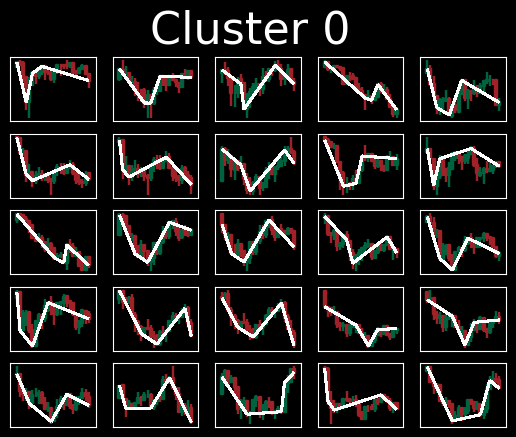

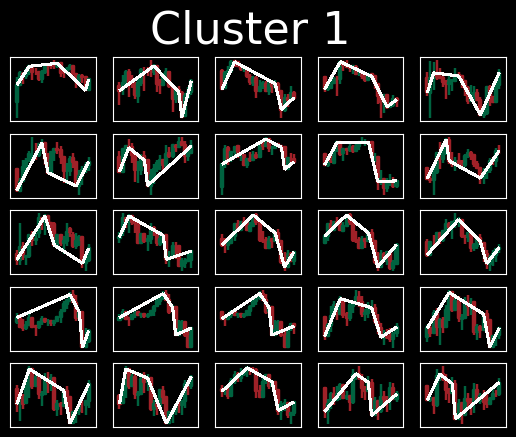

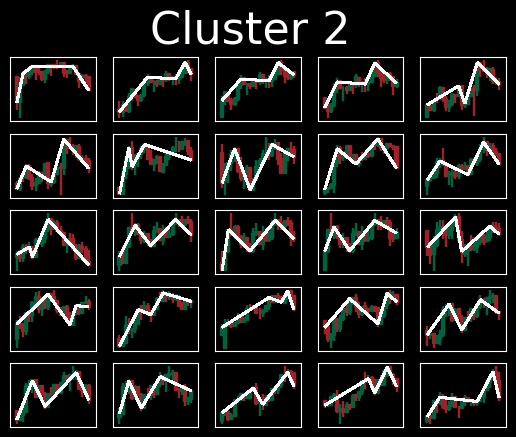

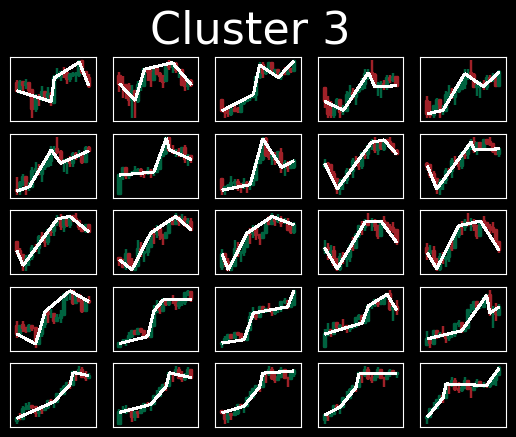

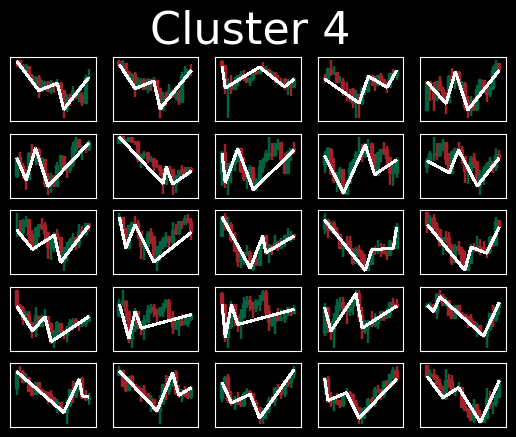

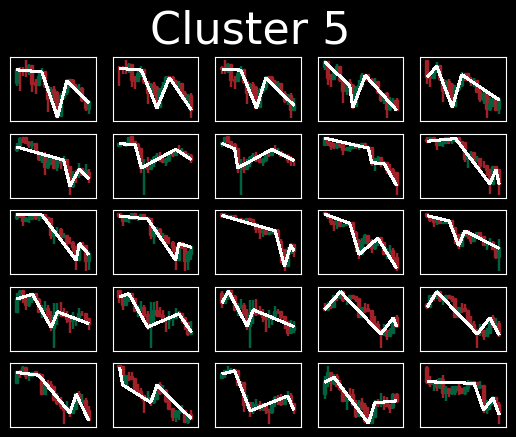

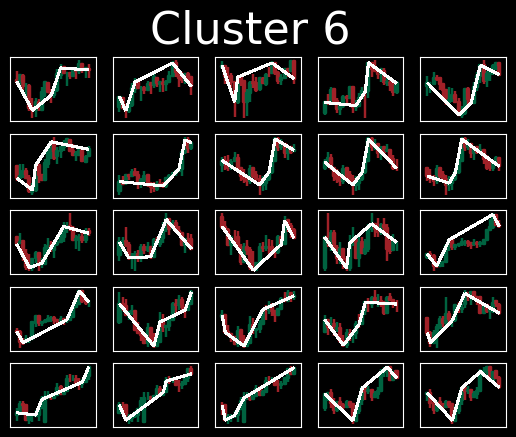

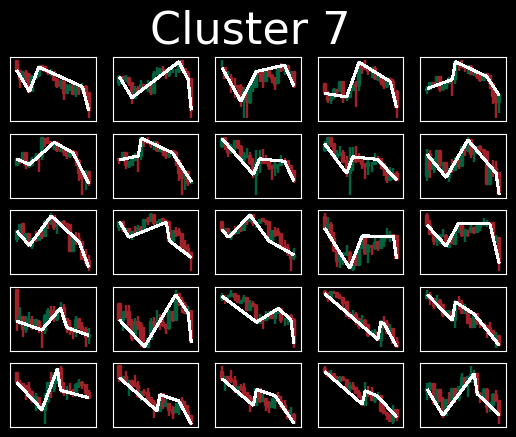

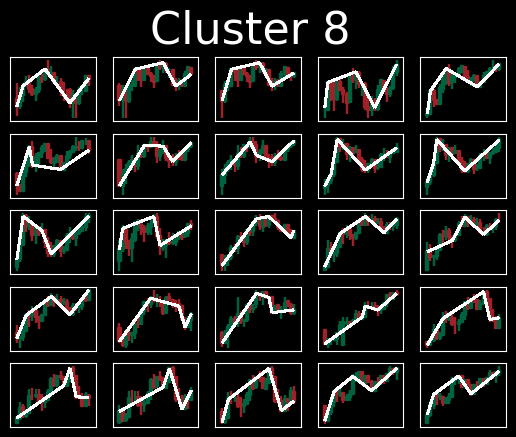

In [96]:
for i in range(0,9):
    plot_cluster_examples(convert_to_pandas(), cluster_i=i, grid_size=5)